## 주식 예측에 도전해 보자

### STEP 1 : 시계열 데이터 준비
 - 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
 - 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장
 - 종가(Close)만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
dataset_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_path, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행
 - 결측치 처리
 - 로그 변환

In [2]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
ts = ts.interpolate(method='time')  # 결측치 없으나, 있다면 보완
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
# 로그변환 시도
ts_log = np.log(ts)    

### STEP 3 : 시계열 안정성 분석
 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인

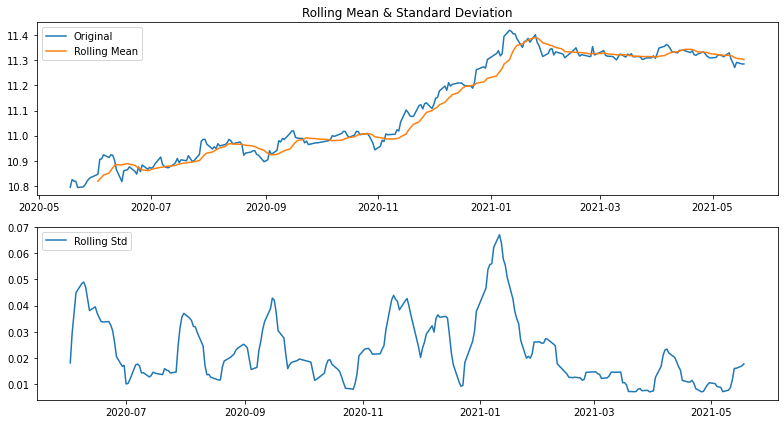

In [5]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() #moving average
    rolstd = timeseries.rolling(window=window).std() # std MA
    plt.rcParams['figure.figsize'] = (11,6)
    plt.subplot(211)
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(loc='upper left')
    plt.subplot(212)
    plt.plot(rolstd, label='Rolling Std')
    plt.legend(loc='upper left')
    plt.tight_layout()
#     orig = plt.plot(timeseries, color='blue', label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label='Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)

plot_rolling_statistics(ts_log, window=12)



In [6]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)' % key] = value
    print(dfoutput)    

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value(1%)              -3.456888
Critical Value(5%)              -2.873219
Critical Value(10%)             -2.572994
dtype: float64


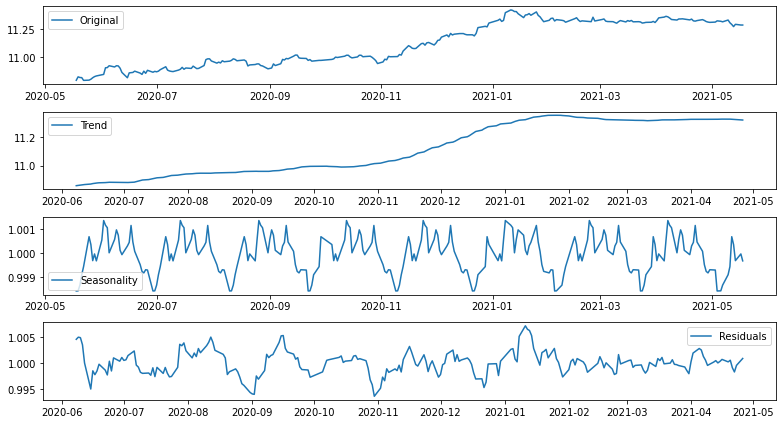

In [7]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value(1%)            -3.461879e+00
Critical Value(5%)            -2.875404e+00
Critical Value(10%)           -2.574159e+00
dtype: float64


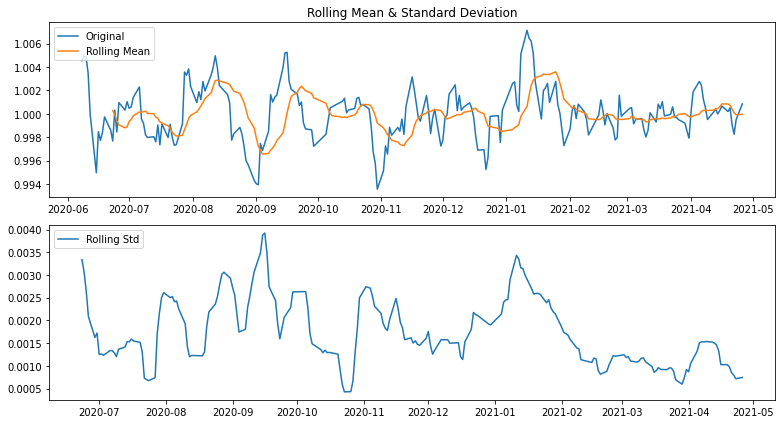

In [8]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### STEP 4 : 학습, 테스트 데이터셋 생성
 - 학습, 테스트 데이터셋 분리

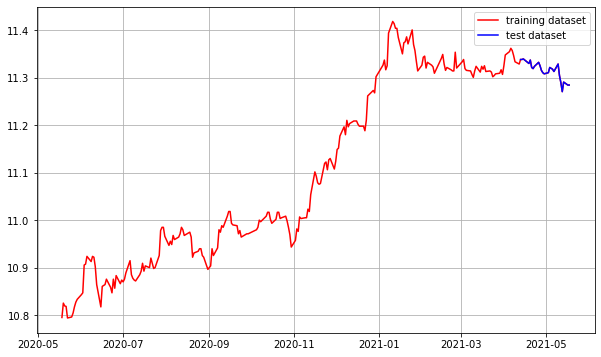

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
 - ACF, PACF 그려보기 -> p,q 구하기
 - 차분 안정성 확인 -> d 구하기

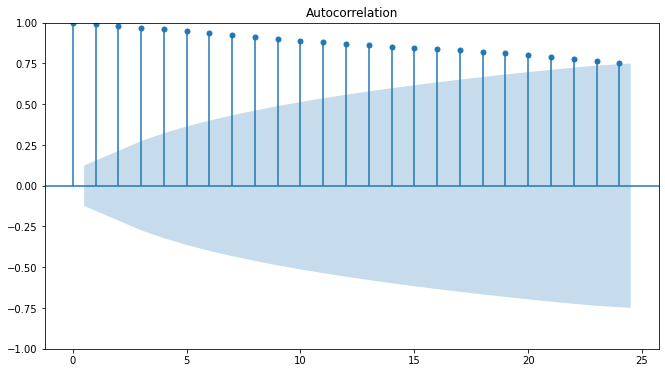

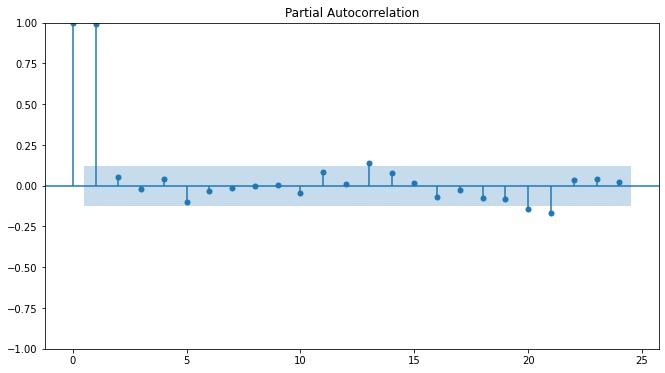

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value(1%)            -3.456996e+00
Critical Value(5%)            -2.873266e+00
Critical Value(10%)           -2.573019e+00
dtype: float64


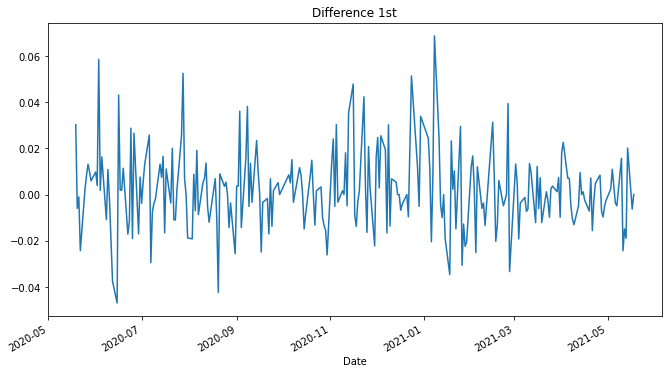

In [11]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value(1%)            -3.457894e+00
Critical Value(5%)            -2.873659e+00
Critical Value(10%)           -2.573229e+00
dtype: float64


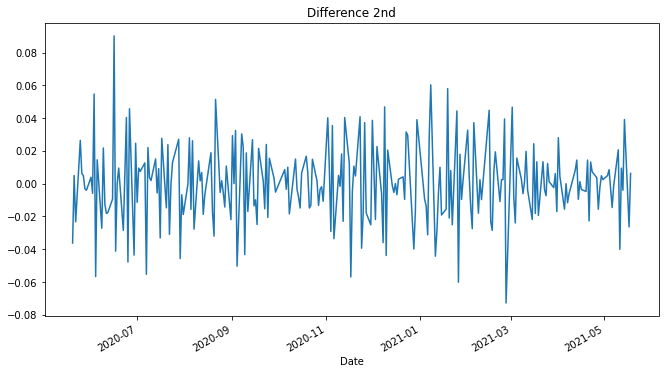

In [12]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트
 - ARIMA 모델 빌드와 훈련
 - 모델 테스트 및 플로팅
 - 최종 예측 모델 정확도 측정(MAPE)

In [13]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 28 Apr 2022   AIC                          -1156.722
Time:                        11:54:00   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

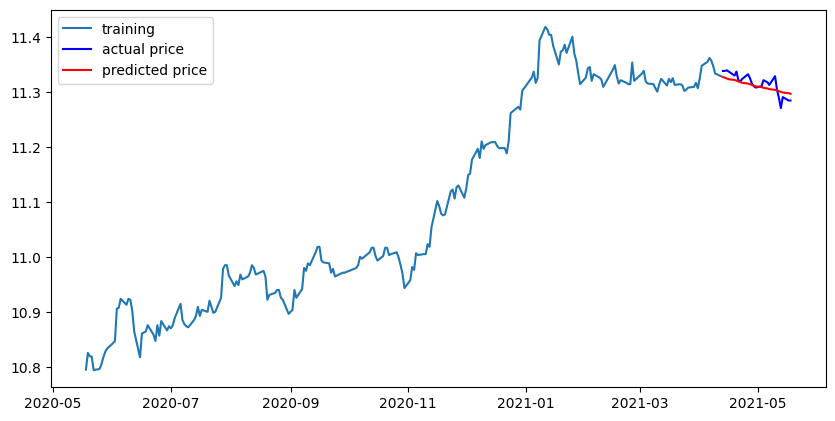

In [14]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
# 원본 스케일의 오차계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7 : 다른 주식 종목 예측해 보기 (한국 KOSPI200 지수 ETF 가격 예측)

In [16]:
# STEP 1 : 시계열 데이터 준비
# Time Series 생성
dataset_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/EWY.csv'
df = pd.read_csv(dataset_path, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2017-04-28    62.099998
2017-05-01    62.450001
2017-05-02    63.290001
2017-05-03    62.840000
2017-05-04    63.009998
Name: Close, dtype: float64

In [17]:
STEP 2 : 각종 전처리 수행
# 결측치 확인 : 없음 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [18]:
# 로그변환
ts_log = np.log(ts)    

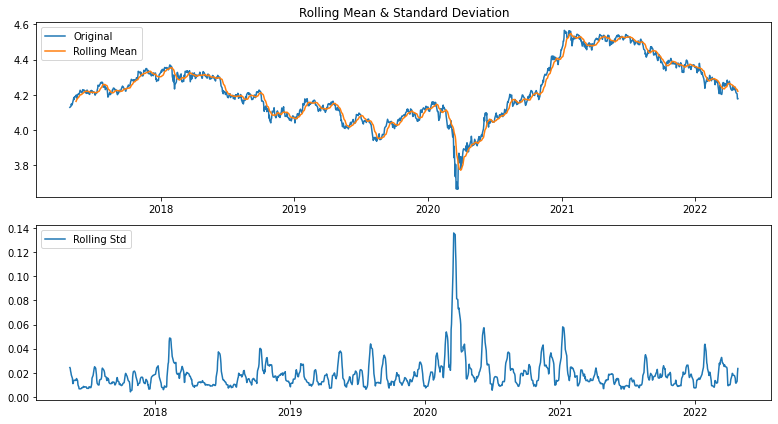

In [19]:
# STEP 3 : 시계열 안정성 분석 : 코로나 시기 급격한 변동성 있음
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [20]:
#정량적 Augmented Dicky-Fuller Test : p-value는 예상외로 낮게 나옴
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.513713
p-value                           0.526717
#Lags Used                       10.000000
Number of Observations Used    1248.000000
Critical Value(1%)               -3.435601
Critical Value(5%)               -2.863859
Critical Value(10%)              -2.568004
dtype: float64


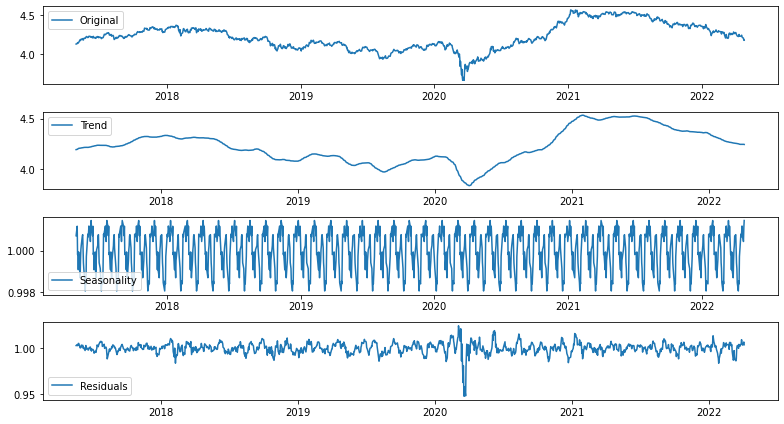

In [21]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                -1.076443e+01
p-value                        2.473382e-19
#Lags Used                     1.900000e+01
Number of Observations Used    1.209000e+03
Critical Value(1%)            -3.435770e+00
Critical Value(5%)            -2.863934e+00
Critical Value(10%)           -2.568044e+00
dtype: float64


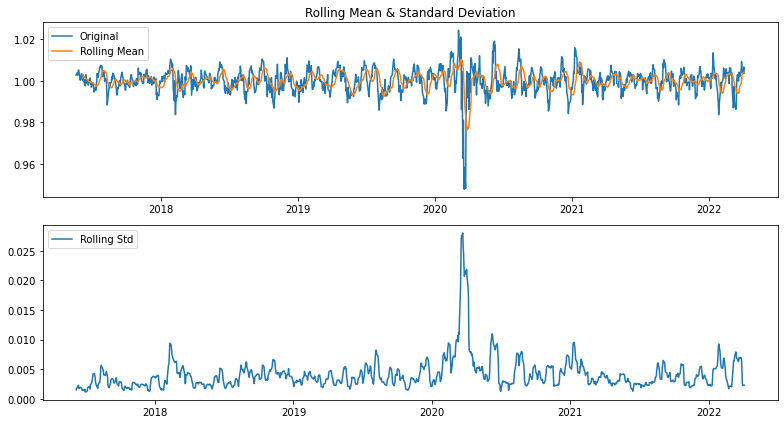

In [22]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

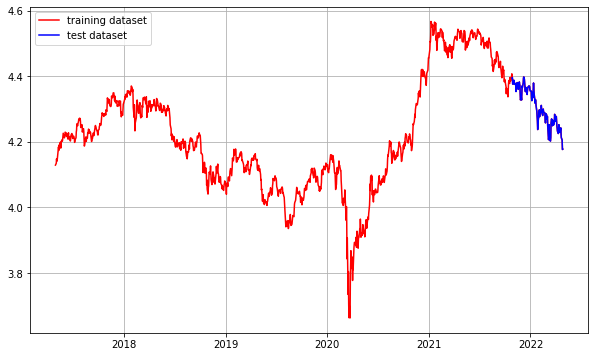

In [23]:
# STEP 4 : 학습, 테스트 데이터셋 생성
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

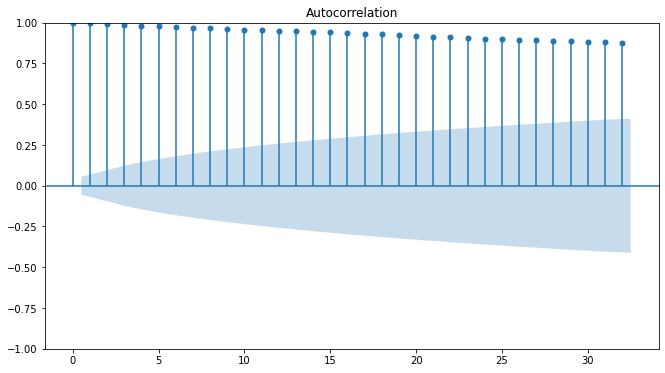

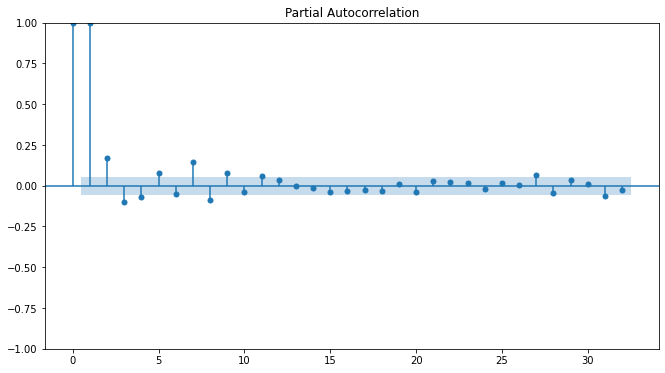

In [24]:
# STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.198221e+01
p-value                        3.682423e-22
#Lags Used                     9.000000e+00
Number of Observations Used    1.248000e+03
Critical Value(1%)            -3.435601e+00
Critical Value(5%)            -2.863859e+00
Critical Value(10%)           -2.568004e+00
dtype: float64


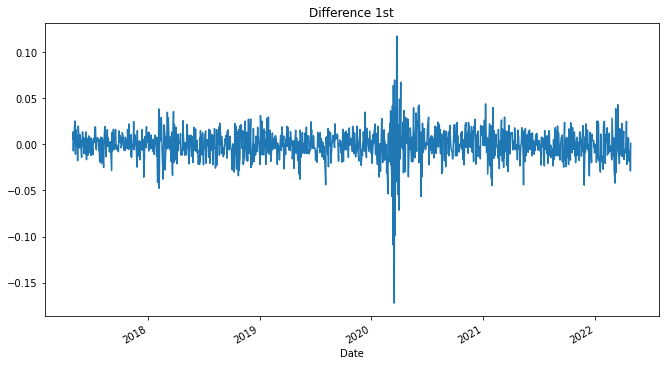

In [25]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [26]:
# STEP 6 : ARIMA 모델 훈련과 테스트 : 차분 이전에 트렌드 항목은 큰 영향이 없었음 --> 차분 0
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(2, 0, 1)   Log Likelihood                3037.026
Date:                Thu, 28 Apr 2022   AIC                          -6064.052
Time:                        12:13:54   BIC                          -6038.889
Sample:                             0   HQIC                         -6054.546
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1599      0.069     60.163      0.000       4.024       4.295
ar.L1          0.3819      0.055      6.936      0.000       0.274       0.490
ar.L2          0.6070      0.054     11.180      0.0

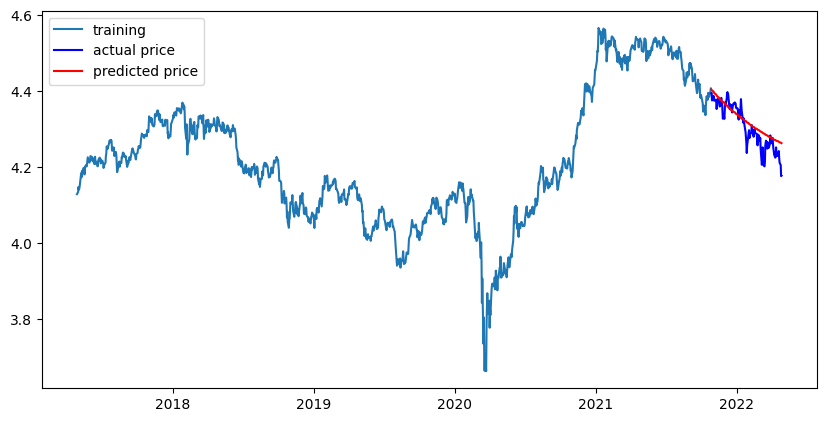

In [27]:
# Forecast : 결과가 fc에 담김
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
# 원본 스케일의 오차계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5.590928629309537
MAE:  1.8754837978257761
RMSE:  2.364514459526424
MAPE: 2.60%


## 회고
 - 주식을 예측할 때 느낌으로 고려하는 주식가격 반등 또는 추세에 대해 통계적인 분석이 가능함을 배웠음
 - ARIMA 모델이 생각보다 주식의 방향을 잘 제시해 주는 것 같음
 - 다만, 향후 언제까지의 주가를 예측하는 것에 대한 다양한 비교가 필요할 것 같음 (단기 예측 및 장기 예측)
 - 한가지 시계열 데이터 외에 다변량의 시계열 데이터가 있을 경우 어떻게 활용가능한지도 검토해야겠음